In [1]:
%matplotlib inline

In [57]:
import requests
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np

from config import nrel_key

In [52]:
fuel = "ELEC"
file_format = "csv"
access = "public"
#country = "US"

params = {
    "api_key": nrel_key,
    "fuel_type": fuel,
    "access": access
    }

base_url = f"https://developer.nrel.gov/api/alt-fuel-stations/v1.json?{params}"

print(base_url)
# response = requests.get(base_url, params=params).json()
# #print(json.dumps(response,indent=4, sort_keys=True))

# df = pd.DataFrame(response["fuel_stations"])
# df

https://developer.nrel.gov/api/alt-fuel-stations/v1.json?{'api_key': 'o2awjV3tGxSyNHaXmOMCcfspdnQeq7yDU17q9BQt', 'fuel_type': 'ELEC', 'access': 'public'}


In [7]:
df_cleaned = df[["access_code","state",'zip','id']]

df_cleaned.head()

,access_code,state,zip,id
0,public,CA,90015,1523
1,public,CA,91731,1583
2,public,CA,92037,6355
3,public,CA,91343,6405
4,public,CA,92503,6425


In [53]:
state_df = df_cleaned.groupby(['state']).count()['id']

print(state_df)

state
AK       60
AL      271
AR      227
AZ      985
CA    15096
CO     1826
CT      564
DC      287
DE      153
FL     2945
GA     1688
HI      368
IA      311
ID      119
IL     1288
IN      400
KA        1
KS      477
KY      240
LA      193
MA     2519
MD     1383
ME      415
MI     1159
MN      602
MO     1081
MS      101
MT      100
NC     1162
ND       82
NE      220
NH      183
NJ      961
NM      244
NV      527
NY     3561
OH     1257
OK      323
ON        8
OR     1028
PA     1352
PR       33
QC        2
RI      313
SC      434
SD       75
TN      667
TX     2611
UT      799
VA     1235
VT      357
WA     1795
WI      482
WV      124
WY       85
Name: id, dtype: int64


In [67]:
ev_registration_path = "resources/ev_registration_by_state.csv"

registration_data = pd.read_csv(ev_registration_path)

registration_data.sort_values(by = "Registration Count", ascending=False)

,State Name,state,Registration Count
4,California,CA,563070.0
9,Florida,FL,95640.0
43,Texas,TX,80900.0
47,Washington,WA,66810.0
32,New York,NY,51870.0
30,New Jersey,NJ,47830.0
2,Arizona,AZ,40740.0
5,Colorado,CO,37000.0
13,Illinois,IL,36520.0
10,Georgia,GA,34020.0


In [22]:
df_complete = pd.merge(state_df, registration_data, how = "left", on=["state"])

df_complete.rename(columns = {"id":"Number of EV Chargers"},inplace=True)

df_complete["Number of EV Chargers"].astype(float)

df_complete.dropna(inplace=True)

df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 54
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  51 non-null     object 
 1   Number of EV Chargers  51 non-null     int64  
 2   State Name             51 non-null     object 
 3   Registration Count     51 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.0+ KB


In [23]:
df_complete['Registration Count'] = pd.to_numeric(df_complete['Registration Count'])

df_complete.info()

df_complete.to_csv(r'df_complete.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 54
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  51 non-null     object 
 1   Number of EV Chargers  51 non-null     int64  
 2   State Name             51 non-null     object 
 3   Registration Count     51 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.0+ KB


In [64]:
reg_expected = df_complete["Registration Count"]

quartiles = reg_expected.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

Values below -34607.5 could be outliers.
Values above 66412.5 could be outliers.


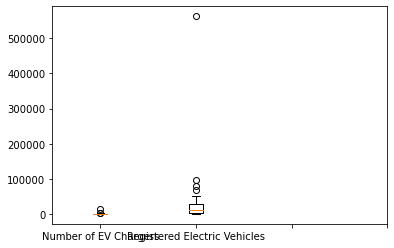

In [62]:
ev_chargers = df_complete['Number of EV Chargers']
reg_count = df_complete['Registration Count']

labels = ["Number of EV Chargers", "Registered Electric Vehicles"]

columns = [ev_chargers,reg_count]

fig, ax = plt.subplots()
ax.boxplot(columns)
plt.xticks([1,2,3,4],labels)
plt.show()

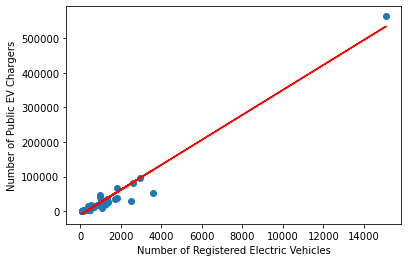

In [60]:
x_values = df_complete['Number of EV Chargers']
y_values = df_complete['Registration Count']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Number of Registered Electric Vehicles')
plt.ylabel('Number of Public EV Chargers')
plt.show()

In [61]:
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.98


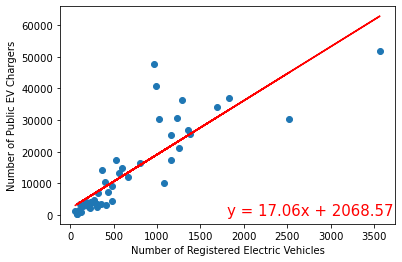

In [70]:
ca_removed = df_complete.loc[df_complete["Registration Count"] < 66412.5]

ca_removed

x_values = ca_removed['Number of EV Chargers']
y_values = ca_removed['Registration Count']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1800,0.8),fontsize=15,color="red",)
plt.xlabel('Number of Registered Electric Vehicles')
plt.ylabel('Number of Public EV Chargers')
plt.show()



In [69]:
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.85
